In [50]:
#Code for plots

import pickle
from datetime import datetime
import numpy as np
from qutip import *
import os
from matplotlib import pyplot as plt
import sys
from scipy.integrate import solve_ivp


def load_all_dynamics(filepath):
    """
    Load multi-dynamics from saved file
    """
    with open(filepath, 'rb') as f:
        loaded_data = pickle.load(f)
    
    print(f"Multi-dynamics loaded from: {filepath}", flush=True)
    print(f"Description: {loaded_data['description']}", flush=True)
    print(f"Timestamp: {loaded_data['timestamp']}", flush=True)
    
    return (loaded_data['full_dynamics'], 
            loaded_data['redfield_dynamics'], 
            loaded_data['rates_dynamics'], 
            loaded_data['parameters'])

def plot_dynamics_from_file(filepath, t_min=None, t_max=None, cavity_ylim=None, save_fig=False, save_name=None):
    """
    Plot dynamics from a saved file given the full file path
    with optional time range selection and saving
    
    Parameters:
    filepath: path to the saved dynamics file
    t_min: minimum time in μs (None for start at 0)
    t_max: maximum time in μs (None for full range)
    cavity_ylim: tuple (min, max) for cavity occupation y-axis limits
    save_fig: boolean, whether to save the figure
    save_name: filename for saving the figure (without extension)
    """
    # Load the dynamics
    full_dynamics, redfield_dynamics, rates_dynamics, parameters = load_all_dynamics(filepath)
    
    # Extract parameters for plotting
    N = parameters['N']
    final_time__mus = parameters['final_time__mus']
    time_steps = parameters['time_steps']
    rabi_freq = parameters['rabi_freq']
    cavity_diss_rate = parameters['cavity_diss_rate']
    eff_coupling = parameters['eff_coupling']
    
    # Calculate expectation values
    x_hamiltonian7 = expect(tensor(qeye(N), sigmax()), full_dynamics)
    z_hamiltonian7 = expect(tensor(qeye(N), sigmaz()), full_dynamics)
    x_redfield = expect(sigmax(), redfield_dynamics)
    z_redfield = expect(sigmaz(), redfield_dynamics)
    x_rates = expect(sigmax(), rates_dynamics)
    z_rates = expect(sigmaz(), rates_dynamics)
    cavity_occupation = expect(tensor(destroy(N).dag() * destroy(N), qeye(2)), full_dynamics)

    # Create time array
    tlist = np.linspace(0, final_time__mus, time_steps)
    
    # Apply time range selection
    if t_min is None:
        t_min = 0
    if t_max is None:
        t_max = final_time__mus
    
    time_mask = (tlist >= t_min) & (tlist <= t_max)
    tlist_plot = tlist[time_mask]
    
    # Apply time mask to all data arrays
    x_hamiltonian7_plot = x_hamiltonian7[time_mask]
    z_hamiltonian7_plot = z_hamiltonian7[time_mask]
    x_redfield_plot = x_redfield[time_mask]
    z_redfield_plot = z_redfield[time_mask]
    x_rates_plot = x_rates[time_mask]
    z_rates_plot = z_rates[time_mask]
    cavity_occupation_plot = cavity_occupation[time_mask]
    
    # Calculate fidelities for the selected time range
    full_dynamics_plot = [full_dynamics[i] for i in range(len(full_dynamics)) if time_mask[i]]
    redfield_dynamics_plot = [redfield_dynamics[i] for i in range(len(redfield_dynamics)) if time_mask[i]]
    rates_dynamics_plot = [rates_dynamics[i] for i in range(len(rates_dynamics)) if time_mask[i]]
    
    fidelity_rates_vs_full = [fidelity(rates_dynamics_plot[i], full_dynamics_plot[i].ptrace(1)) for i in range(len(full_dynamics_plot))]
    fidelity_redfield_vs_full = [fidelity(redfield_dynamics_plot[i], full_dynamics_plot[i].ptrace(1)) for i in range(len(full_dynamics_plot))]

    # Calculate average fidelities
    avg_fidelity_rates = np.mean(fidelity_rates_vs_full)
    avg_fidelity_redfield = np.mean(fidelity_redfield_vs_full)
    final_fidelity_rates = fidelity_rates_vs_full[-1]
    final_fidelity_redfield = fidelity_redfield_vs_full[-1]

    # Create main figure
    fig, axes = plt.subplots(3, 1, figsize=(6, 8))
    
    # Qubit sigma_x
    axes[0].plot(tlist_plot, x_redfield_plot, color='#008000', label="Redfield")
    axes[0].plot(tlist_plot, x_hamiltonian7_plot, color='#000080', label="Hamiltonian 7")
    axes[0].plot(tlist_plot, x_rates_plot, color='#800000', label="Rates")
    axes[0].set_ylabel(r'$ <\sigma_x >$')
    axes[0].legend()
    axes[0].set_ylim(-1.1, 1.1)

    # Qubit sigma_z
    axes[1].plot(tlist_plot, z_redfield_plot, color='#008000', label="Redfield")
    axes[1].plot(tlist_plot, z_hamiltonian7_plot, color='#000080', label="Hamiltonian 7")
    axes[1].plot(tlist_plot, z_rates_plot, color='#800000', label="Rates")
    axes[1].set_ylabel(r'$<\sigma_z >$')
    axes[1].legend()
    axes[1].set_ylim(-1.1, 1.1)
    
    # Cavity occupation
    axes[2].plot(tlist_plot, cavity_occupation_plot, color='#FF8C00', label="Cavity Occupation", linewidth=2)
    axes[2].set_ylabel(r'$ \langle a^\dagger a \rangle $')
    axes[2].set_xlabel('Time (μs)')
    axes[2].legend()
    
    # Set cavity y-axis limits
    if cavity_ylim is not None:
        axes[2].set_ylim(cavity_ylim)
    else:
        axes[2].set_ylim(bottom=0)

    # Build title with parameters and fidelities
    params_text = []
    params_text.append(f"Rabi: {rabi_freq/(2*np.pi*1e6):.1f} MHz")
    params_text.append(f"κ: {cavity_diss_rate/(2*np.pi*1e6):.1f} MHz")
    params_text.append(f"g: {eff_coupling/(2*np.pi*1e6):.1f} MHz")
    
    if t_min != 0 or t_max != final_time__mus:
        params_text.append(f"Time: [{t_min}-{t_max}]μs")

    plt.suptitle(' | '.join(params_text), y=0.98)
    
    # Add fidelity information as text in the first subplot
    fidelity_text = f'Fidelity (avg): Rates={avg_fidelity_rates:.3f}, Redfield={avg_fidelity_redfield:.3f}\nFidelity (final): Rates={final_fidelity_rates:.3f}, Redfield={final_fidelity_redfield:.3f}'
    axes[0].text(0.02, 0.98, fidelity_text, transform=axes[0].transAxes, fontsize=9,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    plt.tight_layout()
    
    # Save figure if requested
    if save_fig:
        if save_name is None:
            # Generate default name from parameters
            save_name = f"dynamics_R{rabi_freq/(2*np.pi*1e6):.1f}_K{cavity_diss_rate/(2*np.pi*1e6):.1f}_G{eff_coupling/(2*np.pi*1e6):.1f}"
        save_path = f"{save_name}.png"
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Figure saved as: {save_path}")
    
    plt.show()
    
    # Create separate fidelity plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

    # Fidelity plot
    ax1.plot(tlist_plot, fidelity_rates_vs_full, label='Rates vs Full', linewidth=2, color='#800000')
    ax1.plot(tlist_plot, fidelity_redfield_vs_full, label='Redfield vs Full', linewidth=2, color='#008000')
    ax1.set_xlabel('Time (μs)')
    ax1.set_ylabel('Fidelity')
    ax1.legend()
    ax1.set_ylim(0, 1.05)
    ax1.set_title('Fidelity Comparison')
    ax1.grid(True, alpha=0.3)

    # Average fidelity bar plot
    methods = ['Rates vs Full', 'Redfield vs Full']
    avg_fidelities = [avg_fidelity_rates, avg_fidelity_redfield]
    bars = ax2.bar(methods, avg_fidelities, color=['#800000', '#008000'])
    ax2.set_ylabel('Average Fidelity')
    ax2.set_ylim(0, 1.05)
    ax2.set_title('Average Fidelity')

    # Add value labels on bars
    for bar, value in zip(bars, avg_fidelities):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, f'{value:.3f}', 
                 ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    # Print fidelity statistics
    print(f"Average fidelity (Rates vs Full): {avg_fidelity_rates:.4f}")
    print(f"Average fidelity (Redfield vs Full): {avg_fidelity_redfield:.4f}")
    print(f"Final fidelity (Rates vs Full): {final_fidelity_rates:.4f}")
    print(f"Final fidelity (Redfield vs Full): {final_fidelity_redfield:.4f}")

Redfield vs. Rates Presentation

In the rotated frame of the qubit:

\begin{equation*}
    H = \Delta_c  d^\dagger d  - \frac{\overline{\omega}_q}{2} \sigma_z  + 
    \chi \bigl(\alpha d^\dagger + \alpha^* d + d^\dagger d \bigr)\bigl(\frac{\Delta_q'}{\overline{\omega}_q}\sigma_z 
    - \frac{\Omega_R}{\overline{\omega}_q} \sigma_x\bigr).
\end{equation*}

with $\overline{\omega}_q = \sqrt{\Delta_q'^2 + \Omega_R^2}$. We can see that our qubit is coupled to a lossy cavity 
through the system and bath operators

\begin{equation*}
    B = (\alpha d^\dagger + \alpha^* d + d^\dagger d)
\end{equation*}

and

\begin{equation*}
    S = \chi(\frac{\Delta_q'}{\overline{\omega}_q}\sigma_z - \frac{\Omega_R}{\overline{\omega}_q}\omega_x).
\end{equation*}

With this 

\begin{align*}
    C(\tau) = & \braket{\tilde{B}(\tau)\tilde{B}(0) } =  \braket{B(\tau)B(0) } \\
    = &\braket{(\alpha d^\dagger(\tau) + \alpha^* d(\tau) + d^\dagger(\tau) d(\tau))
    (\alpha d^\dagger(0) + \alpha^* d(0) + d^\dagger(0) d(0))} \\
    = & \braket{|\alpha|^2 d(\tau) d^\dagger(0)} = 
    \overline{n} e^{(i\Delta_c -\frac{\kappa}{2})\tau} \braket{d(0)d^\dagger(0)} \\
    = & \overline{n} e^{(i\Delta_c -\frac{\kappa}{2})\tau}.
\end{align*}


The Redfield operator is then given by

\begin{align*}
    Z =& \chi^2\int d\tau \tilde{S}(-\tau) C(\tau) \\ =&\int_0^\infty d\tau (\frac{\Delta_q'}{\overline{\omega}_q} \sigma_z -\frac{\Omega_R}{\overline{\omega}}(e^{-i\overline{\omega}t}\sigma_+ + e^{i\overline{\omega}t}\sigma_-))\overline{n} e^{(i\Delta_c -\frac{\kappa}{2})\tau} \\
    = &  \frac{\Delta_q'}{\overline{\omega}_q}\frac{\chi^2\overline{n}}{-i\Delta_c + \frac{\kappa}{2}} \sigma_z
    -  \frac{\Omega_R}{\overline{\omega}_q}\frac{\chi^2\overline{n}}{i(\overline{\omega}_q -\Delta_c) + \frac{\kappa}{2}} \sigma_+
    - \frac{\Omega_R}{\overline{\omega}_q}\frac{\chi^2\overline{n}}{i(-\overline{\omega}_q -\Delta_c) + \frac{\kappa}{2}} \sigma_-.
\end{align*}

The Redfield equation is the given by:

\begin{equation*}
    \partial_t \hat{\rho} = -\frac{i}{\hbar}[\hat{H},\hat{\rho}] +  (\hat{Z} \hat{\rho}\hat{S} + \hat{S} \hat{\rho}\hat{Z}^\dagger - \hat{S}\hat{Z} \hat{\rho} - \hat{\rho}\hat{Z}^\dagger \hat{S}).
\end{equation*}

And compare with the rates

\begin{align*}
    \Gamma_{\pm} = (\frac{\Omega_R}{\overline{\omega}_q})^2 \frac{\chi^2\overline{n}\kappa/2}{(\overline{\omega}_q \pm 
    \Delta_c)^2 + \kappa^2/4}.
\end{align*}


Multi-dynamics loaded from: redfield_dynamics/normal.pkl
Description: Multi-dynamics for eff_coupling=6283185.307179586MHz
Timestamp: 20251023_132128


Figure saved as: normal_example.png


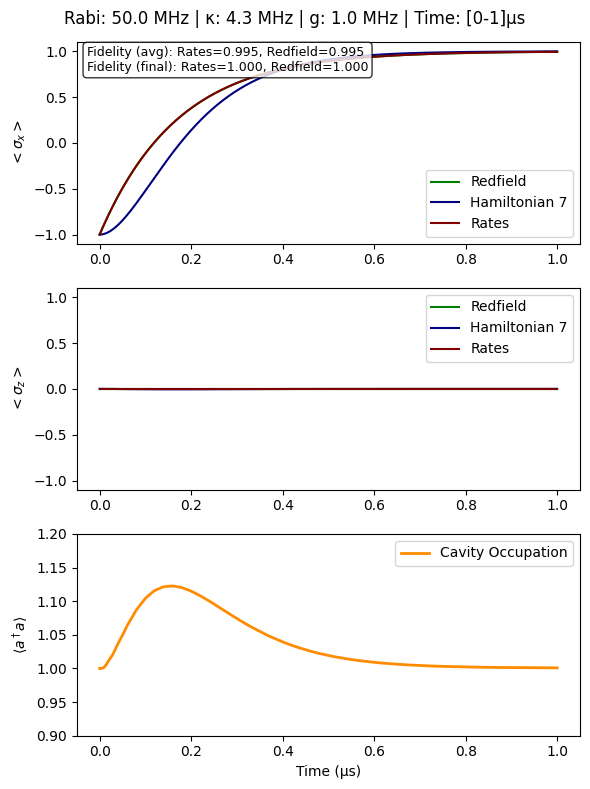

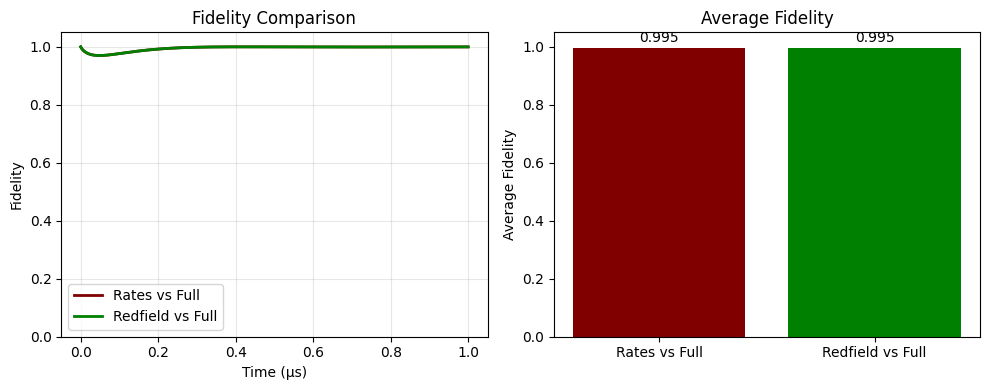

Average fidelity (Rates vs Full): 0.9953
Average fidelity (Redfield vs Full): 0.9953
Final fidelity (Rates vs Full): 0.9998
Final fidelity (Redfield vs Full): 0.9998


In [52]:
#The rate equation should do very good for big $\Omega_R$ frequencies, as the neglected parameters of the RWA oscillate and dephase very fast.
filepath = "redfield_dynamics/normal.pkl"
plot_dynamics_from_file(filepath, t_max=1, cavity_ylim=(0.9,1.2),save_fig=True, save_name="normal_example")

Multi-dynamics loaded from: redfield_dynamics/lower_chi.pkl
Description: Multi-dynamics for eff_coupling=3141592.653589793MHz
Timestamp: 20251023_135346


Figure saved as: lower_chi.png


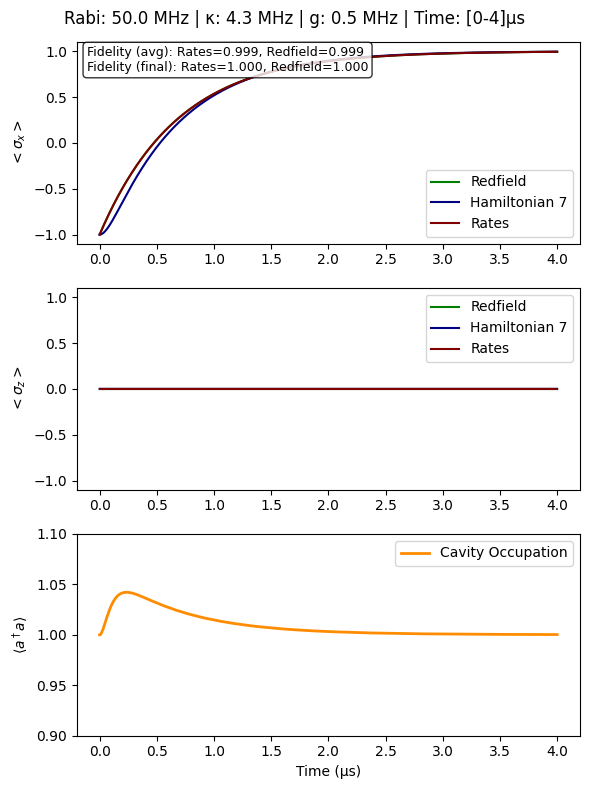

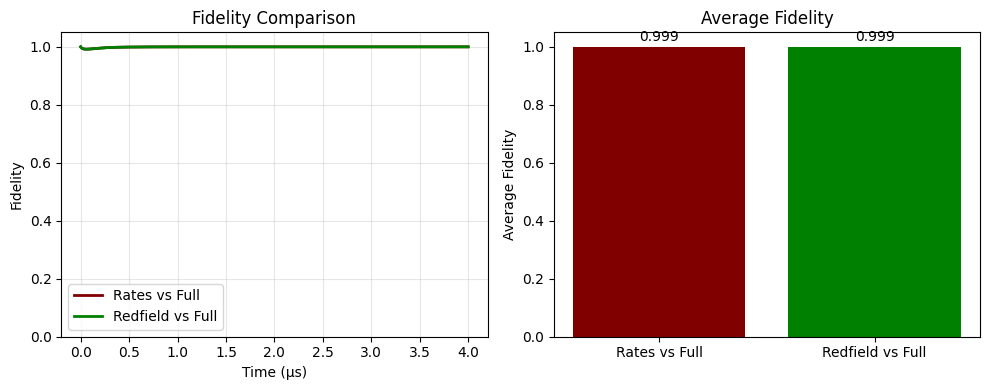

Average fidelity (Rates vs Full): 0.9995
Average fidelity (Redfield vs Full): 0.9995
Final fidelity (Rates vs Full): 1.0000
Final fidelity (Redfield vs Full): 1.0000


In [55]:
#Even better for lower \chi
filepath = "redfield_dynamics/lower_chi.pkl"
plot_dynamics_from_file(filepath, t_max=4, cavity_ylim=(0.9,1.1),save_fig=True, save_name="lower_chi")

Multi-dynamics loaded from: redfield_dynamics/lower_power.pkl
Description: Multi-dynamics for eff_coupling=6283185.307179586MHz
Timestamp: 20251023_134251


Figure saved as: low_power.png


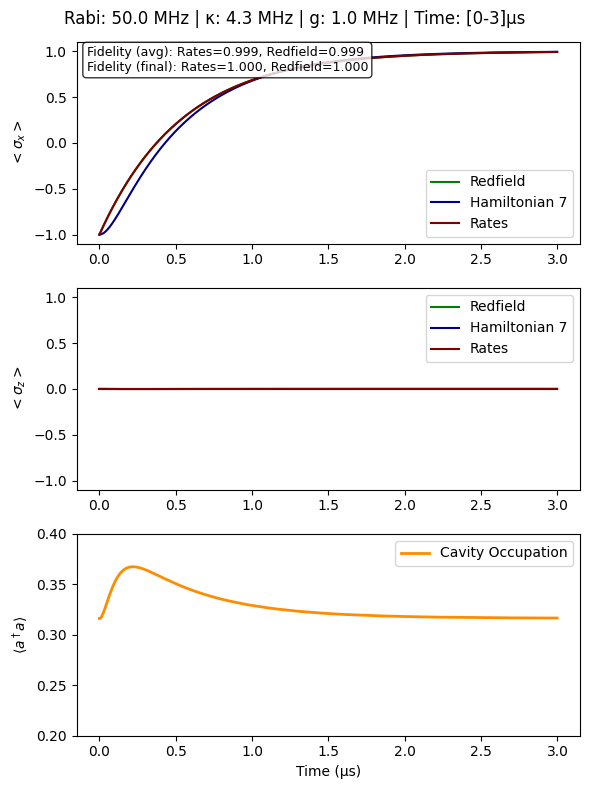

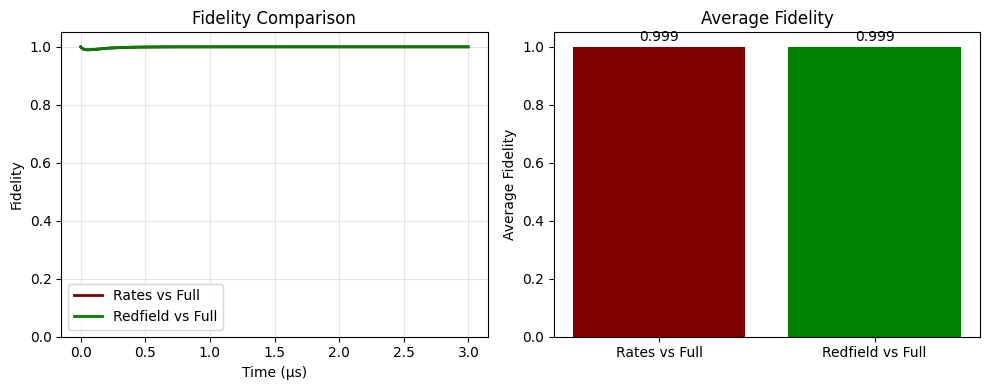

Average fidelity (Rates vs Full): 0.9992
Average fidelity (Redfield vs Full): 0.9992
Final fidelity (Rates vs Full): 1.0000
Final fidelity (Redfield vs Full): 1.0000


In [56]:
#Or lower power
filepath = "redfield_dynamics/lower_power.pkl"
plot_dynamics_from_file(filepath, t_max=3, cavity_ylim=(0.2,0.4),save_fig=True, save_name="low_power")

Multi-dynamics loaded from: redfield_dynamics/lower_rabi.pkl
Description: Multi-dynamics for eff_coupling=6283185.307179586MHz
Timestamp: 20251023_203624


Figure saved as: lower_rabi.png


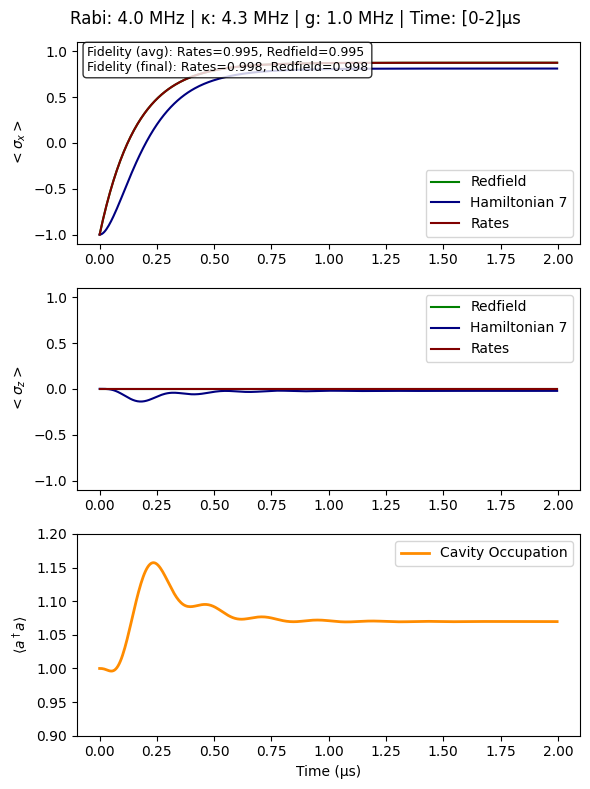

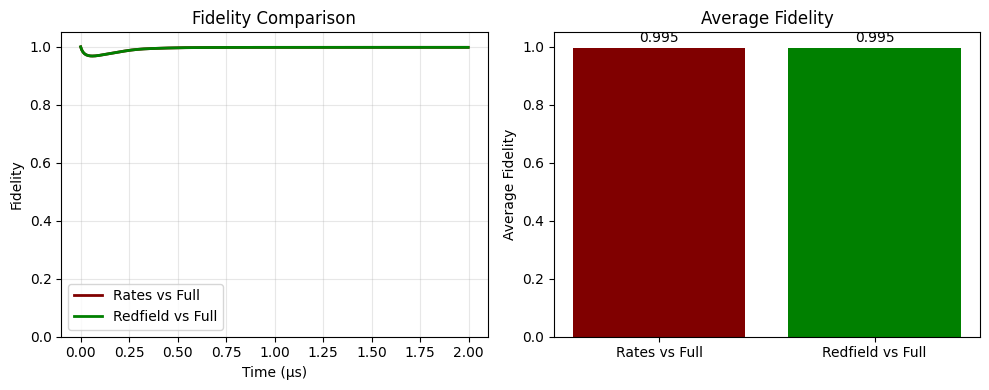

Average fidelity (Rates vs Full): 0.9949
Average fidelity (Redfield vs Full): 0.9949
Final fidelity (Rates vs Full): 0.9982
Final fidelity (Redfield vs Full): 0.9982


In [81]:
#For smaller Rabi frequency we see small oscillations from the counter rotating terms, which Redfield should then captures better.

filepath = "redfield_dynamics/lower_rabi.pkl"
plot_dynamics_from_file(filepath, t_max=2, cavity_ylim=(0.9,1.2),save_fig=True, save_name="lower_rabi")

Multi-dynamics loaded from: redfield_dynamics/high_chi.pkl
Description: Multi-dynamics for eff_coupling=31415926.535897933MHz
Timestamp: 20251023_142306


Figure saved as: high_chi.png


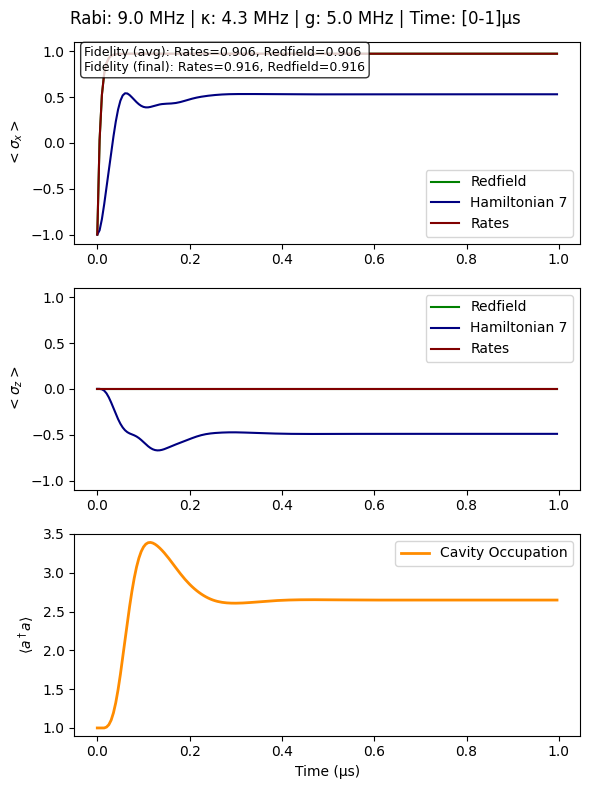

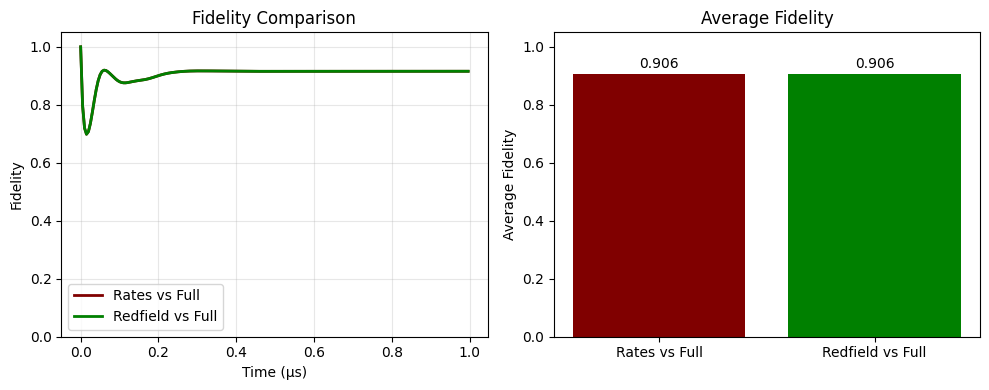

Average fidelity (Rates vs Full): 0.9058
Average fidelity (Redfield vs Full): 0.9058
Final fidelity (Rates vs Full): 0.9157
Final fidelity (Redfield vs Full): 0.9157
Multi-dynamics loaded from: redfield_dynamics/low_kappa.pkl
Description: Multi-dynamics for eff_coupling=6283185.307179586MHz
Timestamp: 20251023_142252
Figure saved as: low_kappa.png


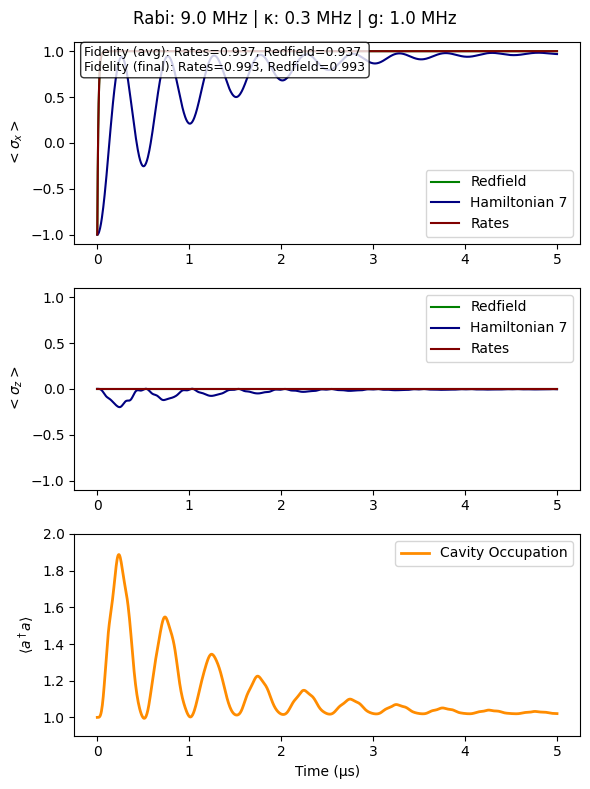

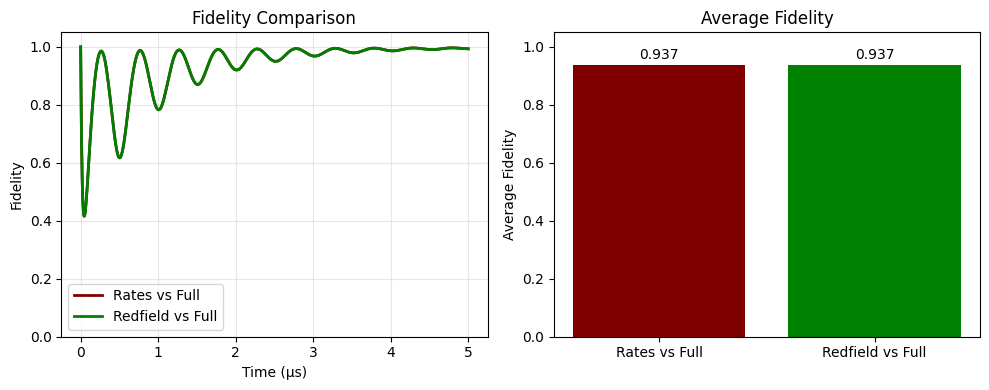

Average fidelity (Rates vs Full): 0.9366
Average fidelity (Redfield vs Full): 0.9366
Final fidelity (Rates vs Full): 0.9931
Final fidelity (Redfield vs Full): 0.9931


In [64]:
#To break any of these we just have to crank up chi, the power or lower the cavity dissipation rate. 

#Here polaron description might help!
filepath = "redfield_dynamics/high_chi.pkl"
plot_dynamics_from_file(filepath, t_max=1, cavity_ylim=(0.9,3.5),save_fig=True, save_name="high_chi")

filepath = "redfield_dynamics/low_kappa.pkl"
plot_dynamics_from_file(filepath, t_max=5, cavity_ylim=(0.9,2),save_fig=True, save_name="low_kappa")

Multi-dynamics loaded from: redfield_dynamics/different_point.pkl
Description: Multi-dynamics for eff_coupling=6283185.307179586MHz
Timestamp: 20251023_142209


Figure saved as: different_point.png


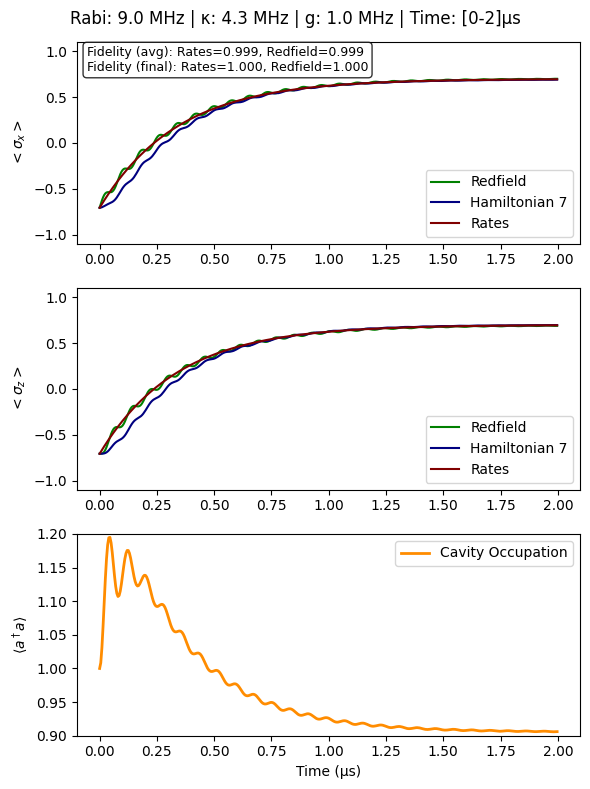

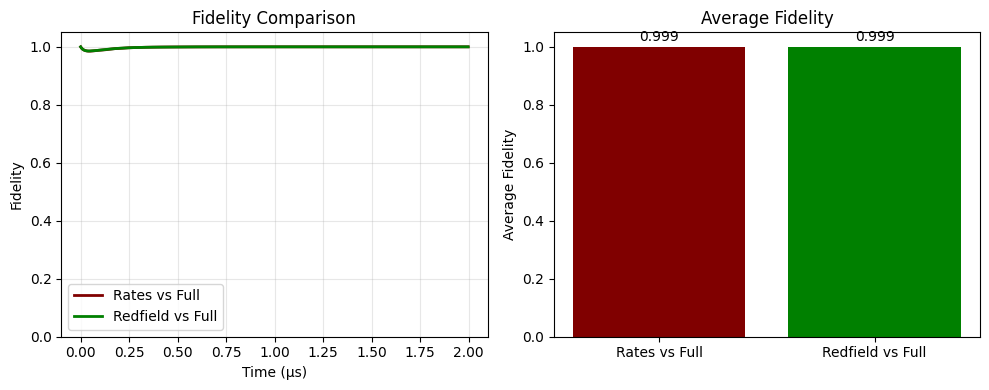

Average fidelity (Rates vs Full): 0.9987
Average fidelity (Redfield vs Full): 0.9987
Final fidelity (Rates vs Full): 1.0000
Final fidelity (Redfield vs Full): 1.0000
Multi-dynamics loaded from: redfield_dynamics/diff_point_comparison.pkl
Description: Multi-dynamics for eff_coupling=6283185.307179586MHz
Timestamp: 20251023_140036
Figure saved as: different_point_comparison.png


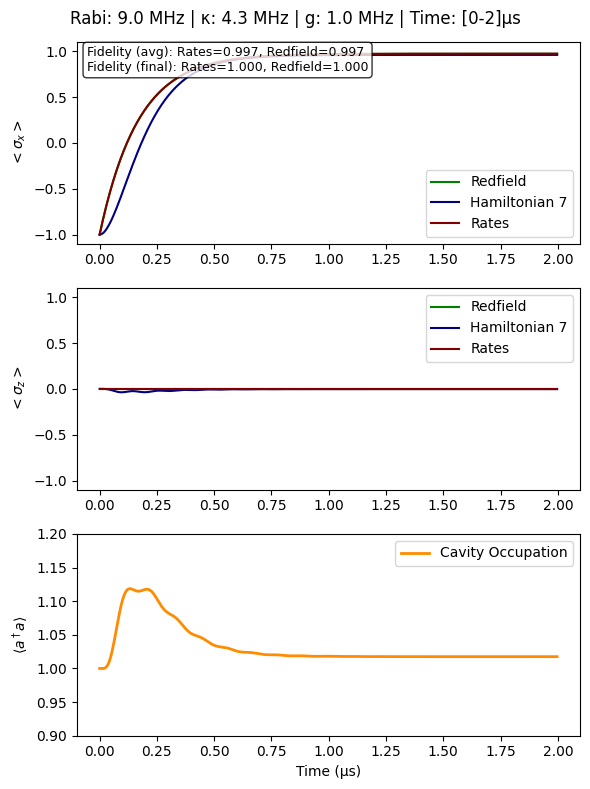

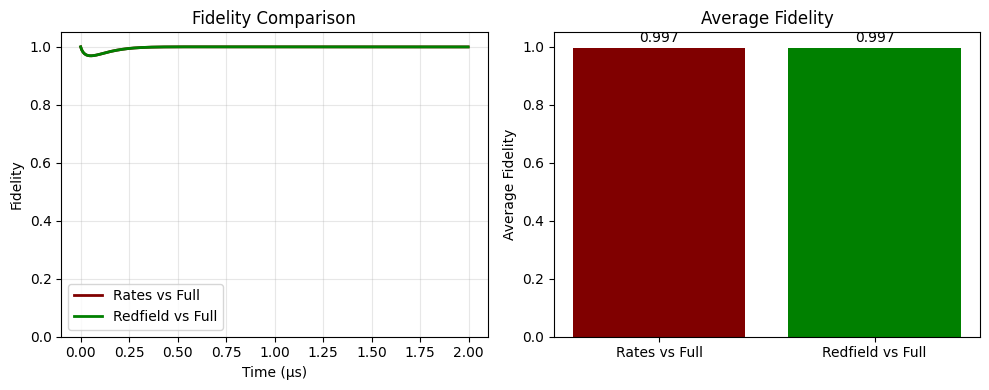

Average fidelity (Rates vs Full): 0.9973
Average fidelity (Redfield vs Full): 0.9973
Final fidelity (Rates vs Full): 0.9997
Final fidelity (Redfield vs Full): 0.9997


In [60]:
#What happens when we want to cool to a different point in the sphere?
#Well the counter oscillations appear earlier and the cooling takes longer but the rest is the same.

filepath = "redfield_dynamics/different_point.pkl"
plot_dynamics_from_file(filepath, t_max=2,cavity_ylim=(0.9,1.2),save_fig=True, save_name="different_point")
filepath = "redfield_dynamics/diff_point_comparison.pkl"
plot_dynamics_from_file(filepath, t_max=2, cavity_ylim=(0.9,1.2),save_fig=True, save_name="different_point_comparison")

Polaron stuff



In [ ]:

def coherent_state_dynamics(t, initial_state, cavity_drive_amplitude, cavity_freq, cavity_diss_rate):
    cavity_field = cavity_drive_amplitude/(-(cavity_freq) + .5j*cavity_diss_rate)
    cavity_state = coherent(N, cavity_field)
    rho_cavity = cavity_state @ cavity_state.dag()
    tdynamics = np.exp(-1j*(cavity_freq*t)-cavity_diss_rate*t/2)
    return initial_state*tdynamics + rho_cavity*(1-tdynamics)


def plot_cavity_fidelity_only(filepath, ylim=None):
    """
    Load dynamics from file and plot only the cavity fidelity comparison
    
    Parameters:
    - filepath: Path to the saved dynamics .pkl file
    - ylim: Tuple (ymin, ymax) for y-axis limits. If None, uses default (0.8, 1.1)
    """
    # Load the dynamics and parameters from file
    with open(filepath, 'rb') as f:
        data = pickle.load(f)
    
    full_dynamics = data['full_dynamics']
    parameters = data['parameters']
    
    # Extract parameters
    N = parameters['N']
    cavity_diss_rate = parameters['cavity_diss_rate']
    input_power = parameters['input_power']
    rabi_freq = parameters['rabi_freq']
    eff_coupling = parameters['eff_coupling']
    qubit_targetz = parameters['qubit_targetz']
    final_time__mus = parameters['final_time__mus']
    time_steps = parameters['time_steps']
    
    # Create time array
    tlist_mus = np.linspace(0, final_time__mus, time_steps)
    
    # Calculate qubit expectation values (sigma_z)
    z_hamiltonian7 = np.array([expect(sigmaz(), ptrace(state, 1)) for state in full_dynamics])
    x_hamiltonian7 = np.array([expect(sigmax(), ptrace(state, 1)) for state in full_dynamics])
    y_hamiltonian7 = np.array([expect(sigmay(), ptrace(state, 1)) for state in full_dynamics])
    
    # Cavity field non polaron
    cavity_photon_number = 10**(input_power/10)
    qubit_detuning = qubit_targetz + eff_coupling*(2*cavity_photon_number + 1) 
    qubit_detuning_lamb_shift = qubit_detuning - eff_coupling*(2*cavity_photon_number + 1)
    cavity_detuning = (qubit_detuning_lamb_shift**2 + rabi_freq**2)**.5
    cavity_drive_amplitude = np.real((cavity_photon_number * (cavity_detuning**2 + .25*cavity_diss_rate**2))**.5)
    cavity_field = cavity_drive_amplitude/(-cavity_detuning + .5j*cavity_diss_rate)

    # Non-polaron cavity state
    cavity_state_np = coherent(N, cavity_field)
    rho_cavity_np = cavity_state_np @ cavity_state_np.dag()

    # Get cavity dynamics by tracing out qubit
    cavity_dynamics = np.array([ptrace(i, 0) for i in full_dynamics])

    # Fidelity with non-polaron cavity state
    non_polaron_fid = np.array([fidelity(rho_cavity_np, i) for i in cavity_dynamics])

    # Calculate the other two cavity fields
    cavity_field_e = cavity_drive_amplitude/(-(cavity_detuning + eff_coupling) + .5j*cavity_diss_rate)
    cavity_field_g = cavity_drive_amplitude/(-(cavity_detuning - eff_coupling) + .5j*cavity_diss_rate)

    rho_cavity_e_t = np.array([coherent_state_dynamics(i, rho_cavity_np, cavity_drive_amplitude, cavity_detuning + eff_coupling, cavity_diss_rate) for i in tlist_mus/1e-6])
    rho_cavity_g_t = np.array([coherent_state_dynamics(i, rho_cavity_np, cavity_drive_amplitude, cavity_detuning - eff_coupling, cavity_diss_rate) for i in tlist_mus/1e-6])
# Calculate fidelities with these states

    # Create coherent states for the other two fields
    cavity_state_e_t = [coherent(N, i) for i in rho_cavity_e_t]
    cavity_state_g_t =  [coherent(N, i) for i in rho_cavity_g_t]

    rho_cavity_e = [i @ i.dag() for i in cavity_state_e_t]
    rho_cavity_g = [i @ i.dag() for i in cavity_state_g_t]

    # Calculate fidelities with these states
    fidelity_e = np.array([fidelity(rho_cavity_e, i) for i in cavity_dynamics])
    fidelity_g = np.array([fidelity(rho_cavity_g, i) for i in cavity_dynamics])

    # Calculate qubit populations using existing z_hamiltonian7
    P_e = (1 + z_hamiltonian7) / 2
    P_g = (1 - z_hamiltonian7) / 2

    # Create time-dependent superposition cavity field
    cavity_field_superposition = P_e * cavity_field_e + P_g * cavity_field_g

    # Calculate fidelities with the superposition state at each time
    fidelity_superposition = np.zeros_like(fidelity_e)
    for i, (cav_rho, alpha_sup) in enumerate(zip(cavity_dynamics, cavity_field_superposition)):
        cavity_state_sup = coherent(N, alpha_sup)
        rho_cavity_sup = cavity_state_sup @ cavity_state_sup.dag()
        fidelity_superposition[i] = fidelity(rho_cavity_sup, cav_rho)

    # Create title with important parameters
    title = (f"Cavity State Fidelity\n"
             f"Δ₀={qubit_targetz:.1f}MHz, g={eff_coupling/(2*np.pi*1e6):.1f}MHz, "
             f"Ω={rabi_freq/(2*np.pi*1e6):.1f}MHz, κ={cavity_diss_rate/(2*np.pi*1e6):.1f}MHz, "
             f"P={input_power}dB, N={N}")

    # Plot only the first fidelity plot
    plt.figure(figsize=(12, 6))
    
    plt.plot(tlist_mus, non_polaron_fid, 'b-', linewidth=2, label='Non-polaron cavity')
    plt.plot(tlist_mus, fidelity_e, 'r-', linewidth=2, label='Cavity field (qubit excited)')
    plt.plot(tlist_mus, fidelity_g, 'g-', linewidth=2, label='Cavity field (qubit ground)')
    plt.plot(tlist_mus, fidelity_superposition, 'm-', linewidth=3, label='Weighted superposition')

    plt.xlabel('Time (μs)')
    plt.ylabel('Fidelity')
    plt.title(title, fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Set y-axis limits based on user input
    if ylim is not None:
        plt.ylim(ylim)
    else:
        plt.ylim(0.8, 1.1)  # Default limits
    
    plt.tight_layout()
    plt.show()

    # Print summary information
    print("=== FIDELITY SUMMARY ===")
    print(f"Non-polaron cavity fidelity: max = {np.max(non_polaron_fid):.4f}, avg = {np.mean(non_polaron_fid):.4f}")
    print(f"Qubit excited cavity fidelity: max = {np.max(fidelity_e):.4f}, avg = {np.mean(fidelity_e):.4f}")
    print(f"Qubit ground cavity fidelity: max = {np.max(fidelity_g):.4f}, avg = {np.mean(fidelity_g):.4f}")
    print(f"Superposition fidelity: max = {np.max(fidelity_superposition):.4f}, avg = {np.mean(fidelity_superposition):.4f}")

    # Find best matching state
    fidelity_dict_avg = {
        "Non-polaron cavity": np.mean(non_polaron_fid),
        "Qubit excited cavity": np.mean(fidelity_e),
        "Qubit ground cavity": np.mean(fidelity_g),
        "Weighted superposition": np.mean(fidelity_superposition)
    }

    best_state_avg = max(fidelity_dict_avg, key=fidelity_dict_avg.get)
    best_fidelity_avg = fidelity_dict_avg[best_state_avg]

    print(f"\nBest matching reference state: {best_state_avg} (avg fidelity = {best_fidelity_avg:.4f})")

    return {
        'non_polaron_fid': non_polaron_fid,
        'fidelity_e': fidelity_e,
        'fidelity_g': fidelity_g,
        'fidelity_superposition': fidelity_superposition,
        'tlist_mus': tlist_mus,
        'parameters': parameters
    }

filepath = "redfield_dynamics/lower_chi.pkl"
plot_cavity_fidelity_only(filepath)

filepath = "redfield_dynamics/high_chi.pkl"
plot_cavity_fidelity_only(filepath, ylim=(0.4,1.1))

filepath = "redfield_dynamics/different_point.pkl"
plot_cavity_fidelity_only(filepath, ylim=(0.8,1.1))

filepath = "redfield_dynamics/low_kappa.pkl"
plot_cavity_fidelity_only(filepath, ylim=(0.8,1.1))

filepath = "redfield_dynamics/different_point_high_chi.pkl"
plot_cavity_fidelity_only(filepath, ylim=(0.8,1.1))

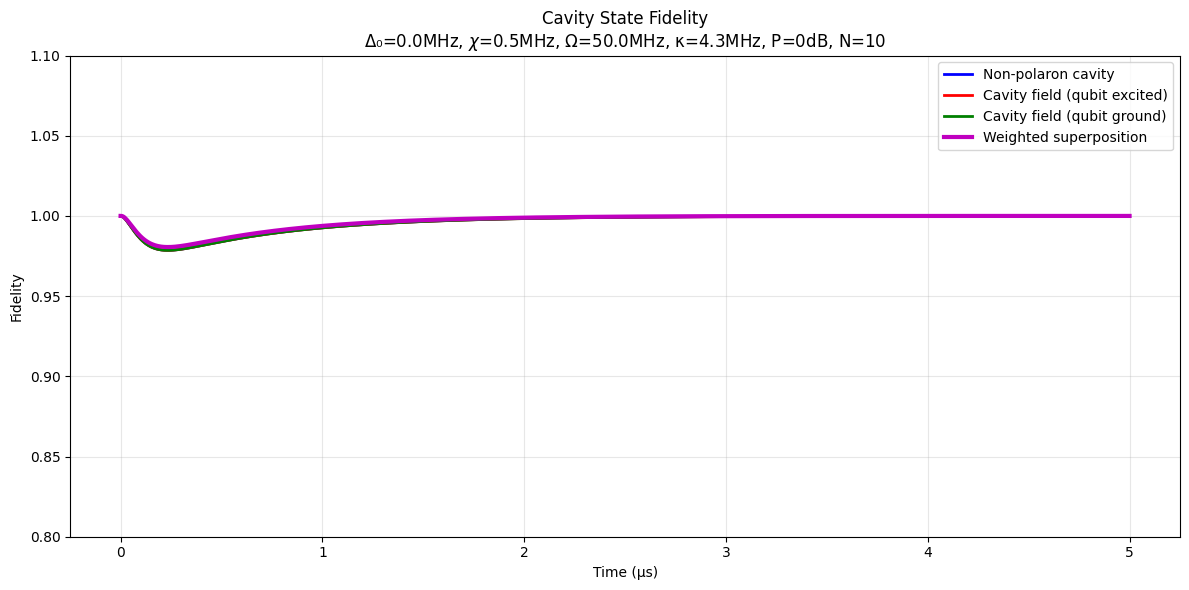

=== FIDELITY SUMMARY ===
Non-polaron cavity fidelity: max = 1.0000, avg = 0.9963
Qubit excited cavity fidelity: max = 1.0000, avg = 0.9962
Qubit ground cavity fidelity: max = 1.0000, avg = 0.9962
Superposition fidelity: max = 1.0000, avg = 0.9968

Best matching reference state: Weighted superposition (avg fidelity = 0.9968)


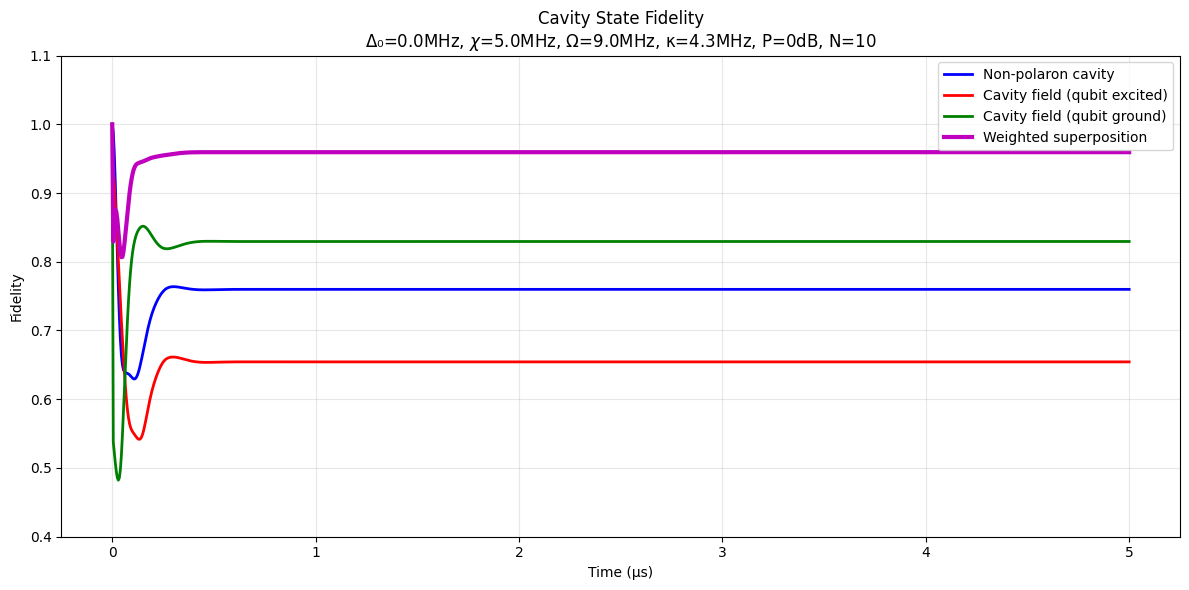

=== FIDELITY SUMMARY ===
Non-polaron cavity fidelity: max = 1.0000, avg = 0.7574
Qubit excited cavity fidelity: max = 1.0000, avg = 0.6539
Qubit ground cavity fidelity: max = 1.0000, avg = 0.8254
Superposition fidelity: max = 1.0000, avg = 0.9570

Best matching reference state: Weighted superposition (avg fidelity = 0.9570)


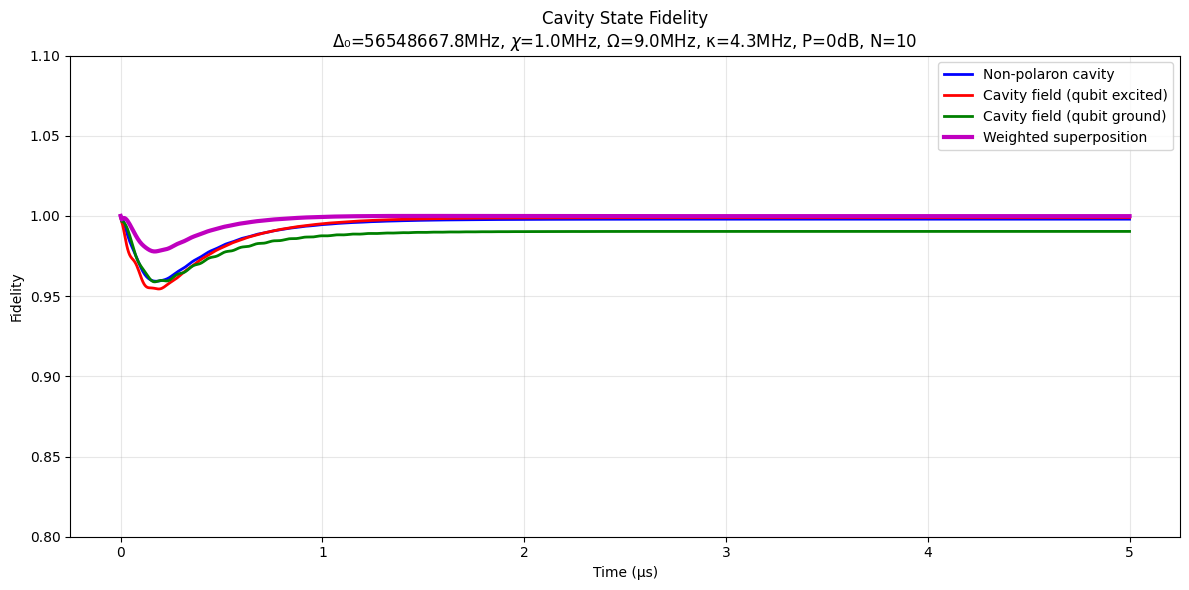

=== FIDELITY SUMMARY ===
Non-polaron cavity fidelity: max = 1.0000, avg = 0.9943
Qubit excited cavity fidelity: max = 1.0000, avg = 0.9947
Qubit ground cavity fidelity: max = 1.0000, avg = 0.9874
Superposition fidelity: max = 1.0000, avg = 0.9982

Best matching reference state: Weighted superposition (avg fidelity = 0.9982)


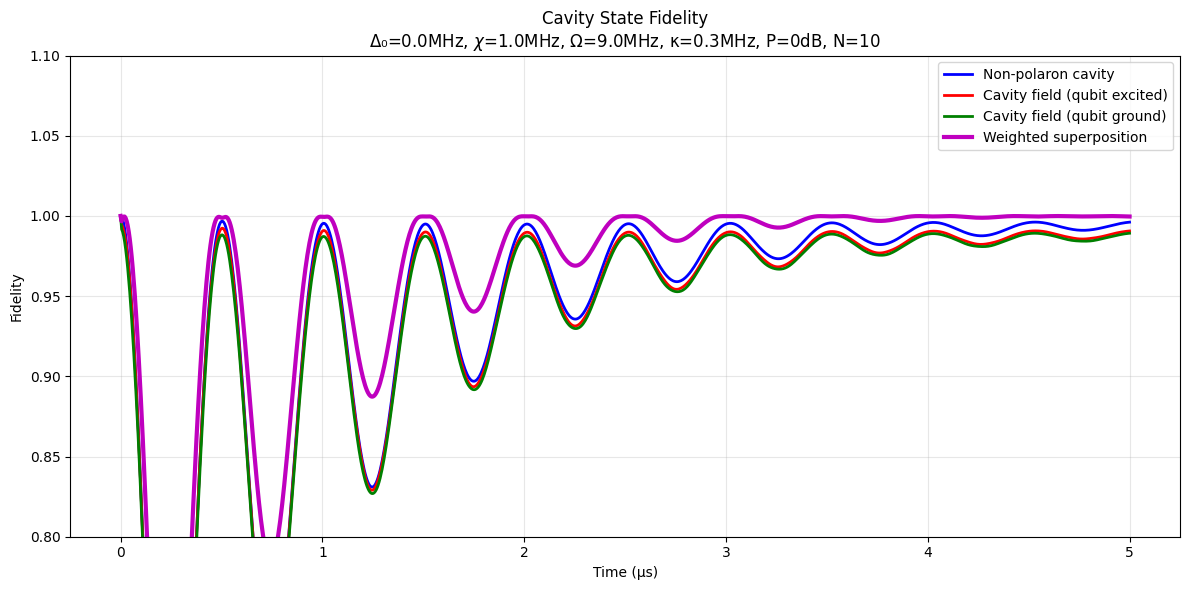

=== FIDELITY SUMMARY ===
Non-polaron cavity fidelity: max = 1.0000, avg = 0.9375
Qubit excited cavity fidelity: max = 1.0000, avg = 0.9337
Qubit ground cavity fidelity: max = 1.0000, avg = 0.9312
Superposition fidelity: max = 1.0000, avg = 0.9614

Best matching reference state: Weighted superposition (avg fidelity = 0.9614)


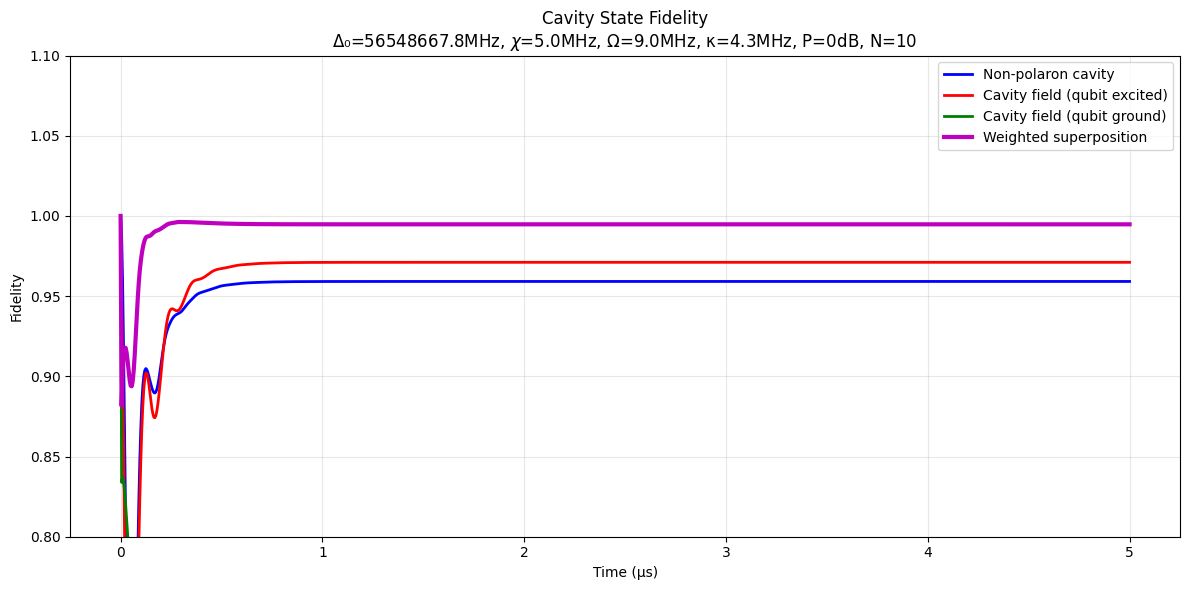

=== FIDELITY SUMMARY ===
Non-polaron cavity fidelity: max = 1.0000, avg = 0.9532
Qubit excited cavity fidelity: max = 1.0000, avg = 0.9632
Qubit ground cavity fidelity: max = 1.0000, avg = 0.7307
Superposition fidelity: max = 1.0000, avg = 0.9932

Best matching reference state: Weighted superposition (avg fidelity = 0.9932)


In [ ]:
### This is the one!!!!

N = 10


def coherent_field_dynamics(t, initial_field, cavity_drive_amplitude, cavity_freq, cavity_diss_rate):
    cavity_field = cavity_drive_amplitude/(-(cavity_freq) + .5j*cavity_diss_rate)

    tdynamics = np.exp(-1j*(cavity_freq*t)-cavity_diss_rate*t/2)
    return initial_field*tdynamics + cavity_field*(1-tdynamics)

def plot_cavity_fidelity_only(filepath, ylim=None):
    """
    Load dynamics from file and plot only the cavity fidelity comparison
    
    Parameters:
    - filepath: Path to the saved dynamics .pkl file
    - ylim: Tuple (ymin, ymax) for y-axis limits. If None, uses default (0.8, 1.1)
    """
    # Load the dynamics and parameters from file
    with open(filepath, 'rb') as f:
        data = pickle.load(f)
    
    full_dynamics = data['full_dynamics']
    parameters = data['parameters']
    
    # Extract parameters
    N = parameters['N']
    cavity_diss_rate = parameters['cavity_diss_rate']
    input_power = parameters['input_power']
    rabi_freq = parameters['rabi_freq']
    eff_coupling = parameters['eff_coupling']
    qubit_targetz = parameters['qubit_targetz']
    final_time__mus = parameters['final_time__mus']
    time_steps = parameters['time_steps']
    
    # Create time array
    tlist_mus = np.linspace(0, final_time__mus, time_steps)
    
    # Calculate qubit expectation values (sigma_z)
    z_hamiltonian7 = np.array([expect(sigmaz(), ptrace(state, 1)) for state in full_dynamics])
    x_hamiltonian7 = np.array([expect(sigmax(), ptrace(state, 1)) for state in full_dynamics])
    y_hamiltonian7 = np.array([expect(sigmay(), ptrace(state, 1)) for state in full_dynamics])
    
    # Cavity field non polaron
    cavity_photon_number = 10**(input_power/10)
    qubit_detuning = qubit_targetz + eff_coupling*(2*cavity_photon_number + 1) 
    qubit_detuning_lamb_shift = qubit_detuning - eff_coupling*(2*cavity_photon_number + 1)
    cavity_detuning = (qubit_detuning_lamb_shift**2 + rabi_freq**2)**.5
    cavity_drive_amplitude = np.real((cavity_photon_number * (cavity_detuning**2 + .25*cavity_diss_rate**2))**.5)
    cavity_field = cavity_drive_amplitude/(-cavity_detuning + .5j*cavity_diss_rate)

    # Non-polaron cavity state
    cavity_state_np = coherent(N, cavity_field)
    rho_cavity_np = cavity_state_np @ cavity_state_np.dag()

    # Get cavity dynamics by tracing out qubit
    cavity_dynamics = np.array([ptrace(i, 0) for i in full_dynamics])
    qubit_dynamics = np.array([ptrace(i,1) for i in full_dynamics])


    # Fidelity with non-polaron cavity state
    non_polaron_fid = np.array([fidelity(rho_cavity_np, i) for i in cavity_dynamics])

    # Calculate the other two cavity fields
    cavity_field_e = cavity_drive_amplitude/(-(cavity_detuning + eff_coupling) + .5j*cavity_diss_rate)
    cavity_field_g = cavity_drive_amplitude/(-(cavity_detuning - eff_coupling) + .5j*cavity_diss_rate)

    rho_cavity_e_t = np.array([coherent_field_dynamics(i, cavity_field, cavity_drive_amplitude, cavity_detuning + eff_coupling, cavity_diss_rate) for i in tlist_mus/1e-6])
    rho_cavity_g_t = np.array([coherent_field_dynamics(i, cavity_field, cavity_drive_amplitude, cavity_detuning - eff_coupling, cavity_diss_rate) for i in tlist_mus/1e-6])
# Calculate fidelities with these states

    # Create coherent states for the other two fields
    cavity_state_e_t = [coherent(N, i) for i in rho_cavity_e_t]
    cavity_state_g_t =  [coherent(N, i) for i in rho_cavity_g_t]

    rho_cavity_e_t = [i @ i.dag() for i in cavity_state_e_t]
    rho_cavity_g_t = [i @ i.dag() for i in cavity_state_g_t]
    rho_cavity_eg_t = [i @ j.dag() for i,j in zip(cavity_state_e_t,cavity_state_g_t)]    


    # Calculate fidelities with these states
    fidelity_e = np.array([fidelity(i, j) for i,j in zip(rho_cavity_e_t,cavity_dynamics)])
    fidelity_g = np.array([fidelity(i, j) for i,j in zip(rho_cavity_g_t,cavity_dynamics)])

    # Calculate qubit populations using existing z_hamiltonian7
    P_e = [i[0,0] for i in qubit_dynamics]
    P_g = [i[1,1] for i in qubit_dynamics]
    C_eg = [i[1,0] for i in qubit_dynamics]
    C_ge = [i[0,1] for i in qubit_dynamics]

    # Create time-dependent superposition cavity field
    cavity_rho_superposition = [P_e[i] * rho_cavity_e_t[i] + P_g[i] * rho_cavity_g_t[i] for i in range(len(P_e))]#+ C_eg[i] * rho_cavity_eg + C_ge[i] * rho_cavity_eg.dag() for i in range(len(P_e))]
    #cavity_rho_superposition = [P_e[i] * rho_cavity_e_t[i] + P_g[i] * rho_cavity_g_t[i] + C_eg[i] * np.conj(C_ge[i]) * rho_cavity_eg_t[i] + C_ge[i] * np.conj(C_eg[i]) * rho_cavity_eg_t[i].dag() for i in range(len(P_e))]
    #cavity_rho_superposition = [i/i.tr() for i in cavity_rho_superposition]
    #print(cavity_rho_superposition)

    # Calculate fidelities with the superposition state at each time
    fidelity_superposition = np.zeros_like(fidelity_e)
    for i, (cav_rho, rho_sup) in enumerate(zip(cavity_dynamics, cavity_rho_superposition)):
        fidelity_superposition[i] = fidelity(cav_rho, rho_sup)

    # Create title with important parameters
    title = (f"Cavity State Fidelity\n"
             f"Δ₀={qubit_targetz:.1f}MHz, "+r"$\chi$" +f"={eff_coupling/(2*np.pi*1e6):.1f}MHz, "
             f"Ω={rabi_freq/(2*np.pi*1e6):.1f}MHz, κ={cavity_diss_rate/(2*np.pi*1e6):.1f}MHz, "
             f"P={input_power}dB, N={N}")

    # Plot only the first fidelity plot
    plt.figure(figsize=(12, 6))
    
    plt.plot(tlist_mus, non_polaron_fid, 'b-', linewidth=2, label='Non-polaron cavity')
    plt.plot(tlist_mus, fidelity_e, 'r-', linewidth=2, label='Cavity field (qubit excited)')
    plt.plot(tlist_mus, fidelity_g, 'g-', linewidth=2, label='Cavity field (qubit ground)')
    plt.plot(tlist_mus, fidelity_superposition, 'm-', linewidth=3, label='Weighted superposition')

    plt.xlabel('Time (μs)')
    plt.ylabel('Fidelity')
    plt.title(title, fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Set y-axis limits based on user input
    if ylim is not None:
        plt.ylim(ylim)
    else:
        plt.ylim(0.8, 1.1)  # Default limits
    
    plt.tight_layout()
    plt.show()

    # Print summary information
    print("=== FIDELITY SUMMARY ===")
    print(f"Non-polaron cavity fidelity: max = {np.max(non_polaron_fid):.4f}, avg = {np.mean(non_polaron_fid):.4f}")
    print(f"Qubit excited cavity fidelity: max = {np.max(fidelity_e):.4f}, avg = {np.mean(fidelity_e):.4f}")
    print(f"Qubit ground cavity fidelity: max = {np.max(fidelity_g):.4f}, avg = {np.mean(fidelity_g):.4f}")
    print(f"Superposition fidelity: max = {np.max(fidelity_superposition):.4f}, avg = {np.mean(fidelity_superposition):.4f}")

    # Find best matching state
    fidelity_dict_avg = {
        "Non-polaron cavity": np.mean(non_polaron_fid),
        "Qubit excited cavity": np.mean(fidelity_e),
        "Qubit ground cavity": np.mean(fidelity_g),
        "Weighted superposition": np.mean(fidelity_superposition)
    }

    best_state_avg = max(fidelity_dict_avg, key=fidelity_dict_avg.get)
    best_fidelity_avg = fidelity_dict_avg[best_state_avg]

    print(f"\nBest matching reference state: {best_state_avg} (avg fidelity = {best_fidelity_avg:.4f})")


filepath = "redfield_dynamics/lower_chi.pkl"
plot_cavity_fidelity_only(filepath)

filepath = "redfield_dynamics/high_chi.pkl"
plot_cavity_fidelity_only(filepath, ylim=(0.4,1.1))

filepath = "redfield_dynamics/different_point.pkl"
plot_cavity_fidelity_only(filepath, ylim=(0.8,1.1))

filepath = "redfield_dynamics/low_kappa.pkl"
plot_cavity_fidelity_only(filepath, ylim=(0.8,1.1))

filepath = "redfield_dynamics/different_point_high_chi.pkl"
plot_cavity_fidelity_only(filepath, ylim=(0.8,1.1))

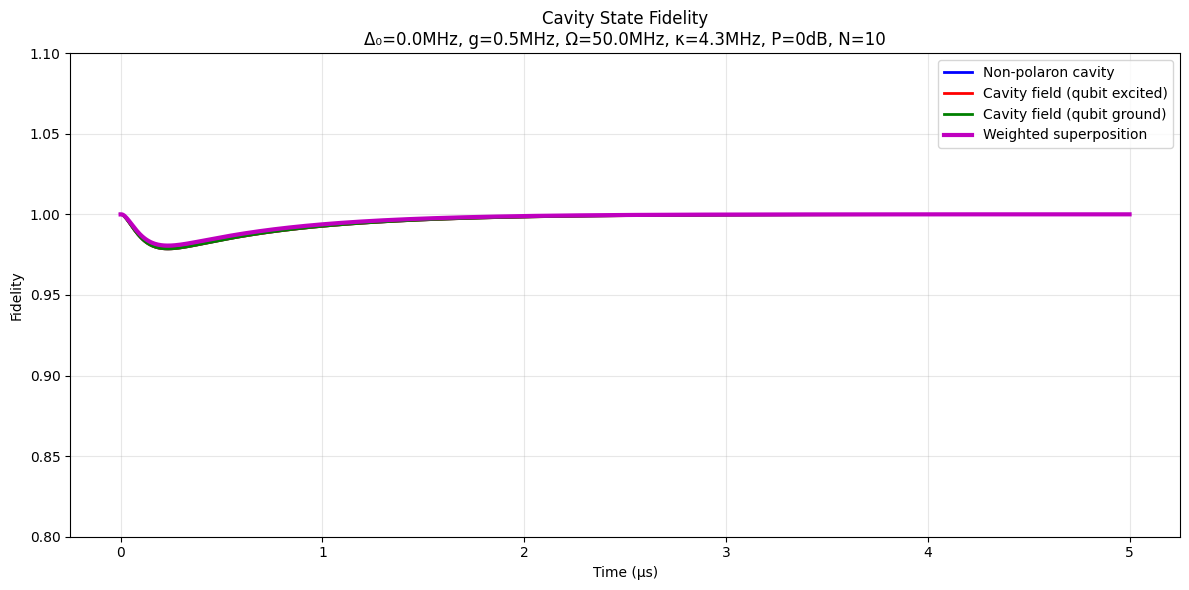

=== FIDELITY SUMMARY ===
Non-polaron cavity fidelity: max = 1.0000, avg = 0.9963
Qubit excited cavity fidelity: max = 1.0000, avg = 0.9962
Qubit ground cavity fidelity: max = 0.9999, avg = 0.9962
Superposition fidelity: max = 1.0000, avg = 0.9968

Best matching reference state: Weighted superposition (avg fidelity = 0.9968)


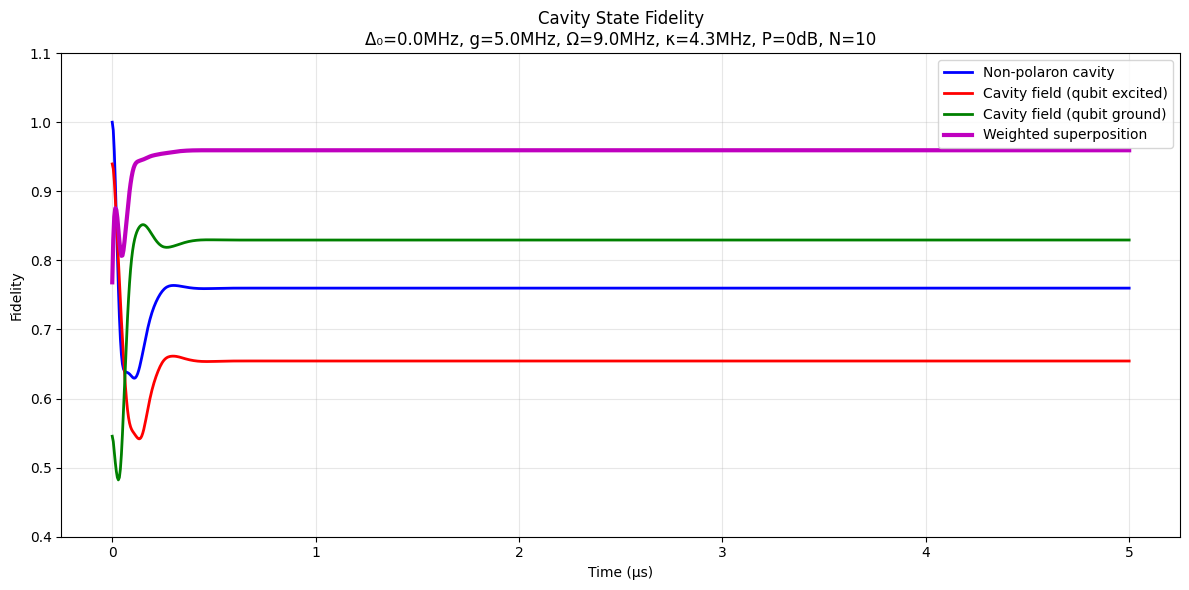

=== FIDELITY SUMMARY ===
Non-polaron cavity fidelity: max = 1.0000, avg = 0.7574
Qubit excited cavity fidelity: max = 0.9396, avg = 0.6538
Qubit ground cavity fidelity: max = 0.8517, avg = 0.8249
Superposition fidelity: max = 0.9594, avg = 0.9568

Best matching reference state: Weighted superposition (avg fidelity = 0.9568)


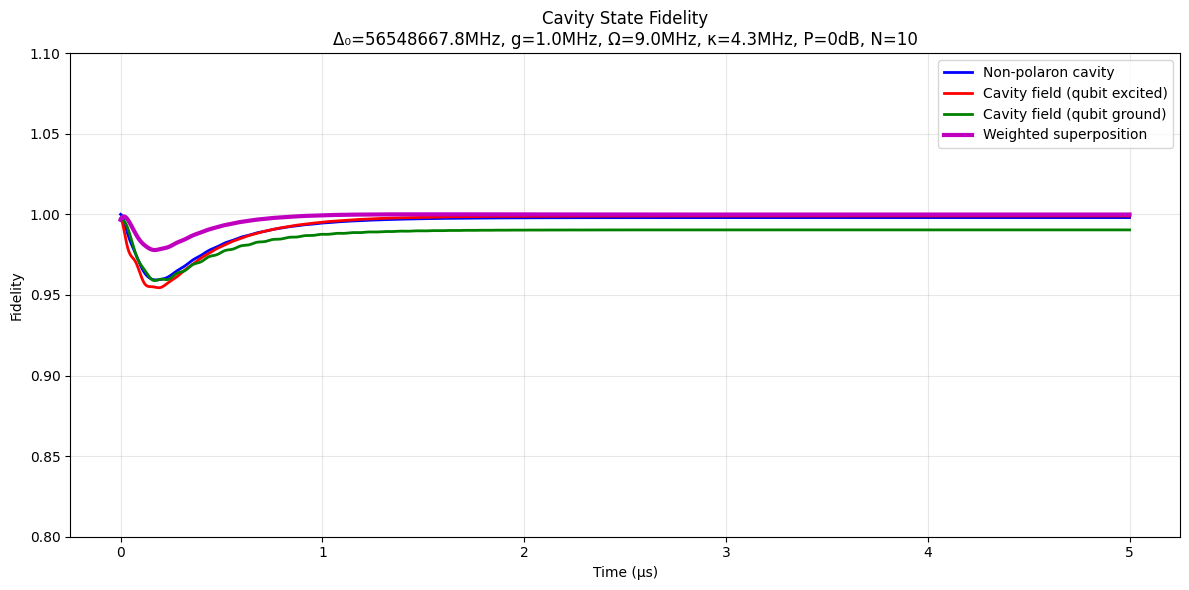

=== FIDELITY SUMMARY ===
Non-polaron cavity fidelity: max = 1.0000, avg = 0.9943
Qubit excited cavity fidelity: max = 0.9990, avg = 0.9947
Qubit ground cavity fidelity: max = 0.9967, avg = 0.9874
Superposition fidelity: max = 1.0000, avg = 0.9982

Best matching reference state: Weighted superposition (avg fidelity = 0.9982)


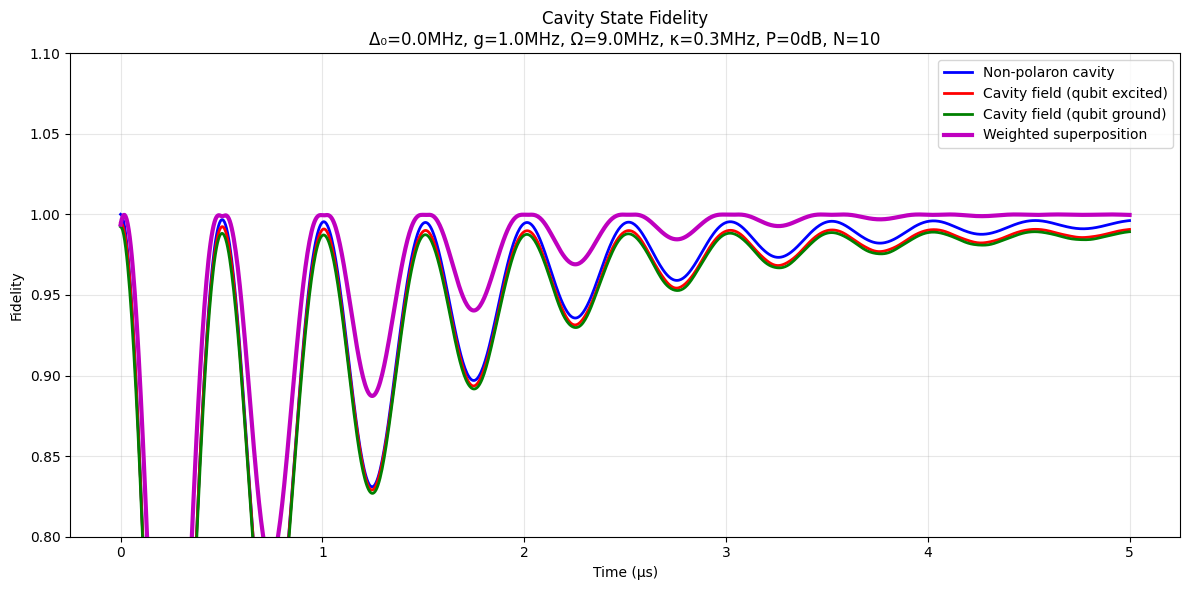

=== FIDELITY SUMMARY ===
Non-polaron cavity fidelity: max = 1.0000, avg = 0.9375
Qubit excited cavity fidelity: max = 0.9950, avg = 0.9337
Qubit ground cavity fidelity: max = 0.9922, avg = 0.9312
Superposition fidelity: max = 0.9999, avg = 0.9614

Best matching reference state: Weighted superposition (avg fidelity = 0.9614)


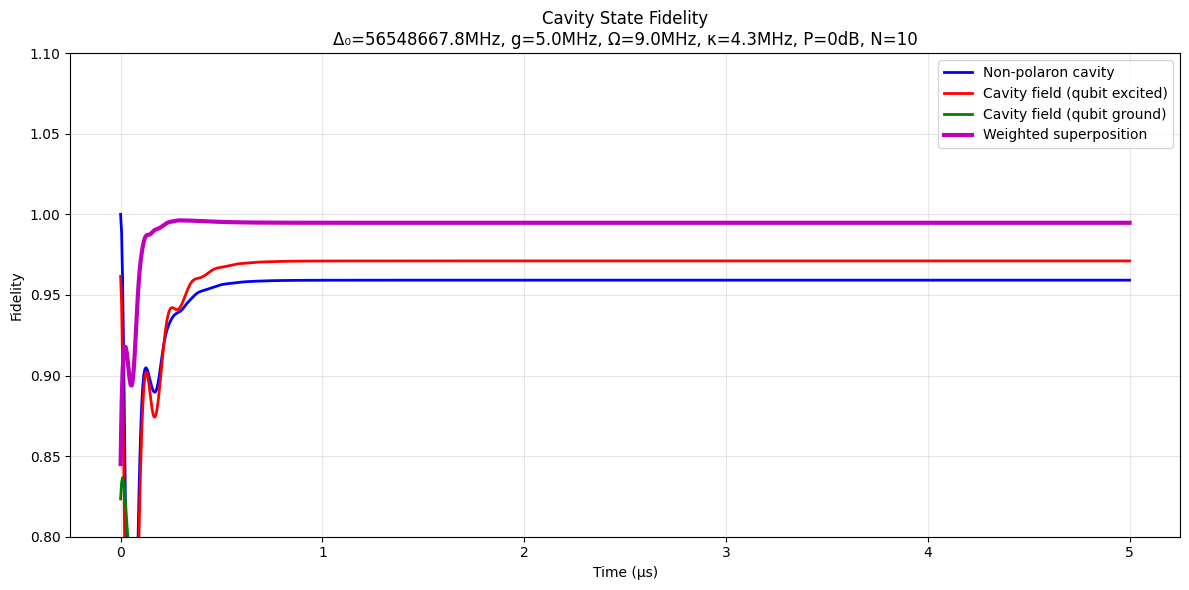

=== FIDELITY SUMMARY ===
Non-polaron cavity fidelity: max = 1.0000, avg = 0.9532
Qubit excited cavity fidelity: max = 0.9711, avg = 0.9632
Qubit ground cavity fidelity: max = 0.8366, avg = 0.7306
Superposition fidelity: max = 0.9962, avg = 0.9930

Best matching reference state: Weighted superposition (avg fidelity = 0.9930)


In [108]:

def plot_cavity_fidelity_only(filepath, ylim=None):
    """
    Load dynamics from file and plot only the cavity fidelity comparison
    
    Parameters:
    - filepath: Path to the saved dynamics .pkl file
    - ylim: Tuple (ymin, ymax) for y-axis limits. If None, uses default (0.8, 1.1)
    """
    # Load the dynamics and parameters from file
    with open(filepath, 'rb') as f:
        data = pickle.load(f)
    
    full_dynamics = data['full_dynamics']
    parameters = data['parameters']
    
    # Extract parameters
    N = parameters['N']
    cavity_diss_rate = parameters['cavity_diss_rate']
    input_power = parameters['input_power']
    rabi_freq = parameters['rabi_freq']
    eff_coupling = parameters['eff_coupling']
    qubit_targetz = parameters['qubit_targetz']
    final_time__mus = parameters['final_time__mus']
    time_steps = parameters['time_steps']
    
    # Create time array
    tlist_mus = np.linspace(0, final_time__mus, time_steps)
    
    # Calculate qubit expectation values (sigma_z)
    z_hamiltonian7 = np.array([expect(sigmaz(), ptrace(state, 1)) for state in full_dynamics])
    x_hamiltonian7 = np.array([expect(sigmax(), ptrace(state, 1)) for state in full_dynamics])
    y_hamiltonian7 = np.array([expect(sigmay(), ptrace(state, 1)) for state in full_dynamics])
    
    # Cavity field non polaron
    cavity_photon_number = 10**(input_power/10)
    qubit_detuning = qubit_targetz + eff_coupling*(2*cavity_photon_number + 1) 
    qubit_detuning_lamb_shift = qubit_detuning - eff_coupling*(2*cavity_photon_number + 1)
    cavity_detuning = (qubit_detuning_lamb_shift**2 + rabi_freq**2)**.5
    cavity_drive_amplitude = np.real((cavity_photon_number * (cavity_detuning**2 + .25*cavity_diss_rate**2))**.5)
    cavity_field = cavity_drive_amplitude/(-cavity_detuning + .5j*cavity_diss_rate)

    # Non-polaron cavity state
    cavity_state_np = coherent(N, cavity_field)
    rho_cavity_np = cavity_state_np @ cavity_state_np.dag()

    # Get cavity dynamics by tracing out qubit
    cavity_dynamics = np.array([ptrace(i, 0) for i in full_dynamics])
    qubit_dynamics = np.array([ptrace(i,1) for i in full_dynamics])


    # Fidelity with non-polaron cavity state
    non_polaron_fid = np.array([fidelity(rho_cavity_np, i) for i in cavity_dynamics])

    # Calculate the other two cavity fields
    cavity_field_e = cavity_drive_amplitude/(-(cavity_detuning + eff_coupling) + .5j*cavity_diss_rate)
    cavity_field_g = cavity_drive_amplitude/(-(cavity_detuning - eff_coupling) + .5j*cavity_diss_rate)

    # Create coherent states for the other two fields
    cavity_state_e = coherent(N, cavity_field_e)
    cavity_state_g = coherent(N, cavity_field_g)

    rho_cavity_e = cavity_state_e @ cavity_state_e.dag()
    rho_cavity_g = cavity_state_g @ cavity_state_g.dag()
    rho_cavity_eg = cavity_state_e @ cavity_state_g.dag()

    # Calculate fidelities with these states
    fidelity_e = np.array([fidelity(rho_cavity_e, i) for i in cavity_dynamics])
    fidelity_g = np.array([fidelity(rho_cavity_g, i) for i in cavity_dynamics])

    # Calculate qubit populations using existing z_hamiltonian7
    P_e = [i[0,0] for i in qubit_dynamics]
    P_g = [i[1,1] for i in qubit_dynamics]
    C_eg = [i[1,0] for i in qubit_dynamics]
    C_ge = [i[0,1] for i in qubit_dynamics]

    # Create time-dependent superposition cavity field
    cavity_rho_superposition = [P_e[i] * rho_cavity_e+ P_g[i] * rho_cavity_g for i in range(len(P_e))]#+ C_eg[i] * rho_cavity_eg + C_ge[i] * rho_cavity_eg.dag() for i in range(len(P_e))]
    #cavity_rho_superposition = [P_e[i] * rho_cavity_e+ P_g[i] * rho_cavity_g + C_eg[i] * rho_cavity_eg + C_ge[i] * rho_cavity_eg.dag() for i in range(len(P_e))]
    #cavity_rho_superposition = [i/i.tr() for i in cavity_rho_superposition]
    #print(cavity_rho_superposition)

    # Calculate fidelities with the superposition state at each time
    fidelity_superposition = np.zeros_like(fidelity_e)
    for i, (cav_rho, rho_sup) in enumerate(zip(cavity_dynamics, cavity_rho_superposition)):
        fidelity_superposition[i] = fidelity(cav_rho, rho_sup)

    # Create title with important parameters
    title = (f"Cavity State Fidelity\n"
             f"Δ₀={qubit_targetz:.1f}MHz, g={eff_coupling/(2*np.pi*1e6):.1f}MHz, "
             f"Ω={rabi_freq/(2*np.pi*1e6):.1f}MHz, κ={cavity_diss_rate/(2*np.pi*1e6):.1f}MHz, "
             f"P={input_power}dB, N={N}")

    # Plot only the first fidelity plot
    plt.figure(figsize=(12, 6))
    
    plt.plot(tlist_mus, non_polaron_fid, 'b-', linewidth=2, label='Non-polaron cavity')
    plt.plot(tlist_mus, fidelity_e, 'r-', linewidth=2, label='Cavity field (qubit excited)')
    plt.plot(tlist_mus, fidelity_g, 'g-', linewidth=2, label='Cavity field (qubit ground)')
    plt.plot(tlist_mus, fidelity_superposition, 'm-', linewidth=3, label='Weighted superposition')

    plt.xlabel('Time (μs)')
    plt.ylabel('Fidelity')
    plt.title(title, fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Set y-axis limits based on user input
    if ylim is not None:
        plt.ylim(ylim)
    else:
        plt.ylim(0.8, 1.1)  # Default limits
    
    plt.tight_layout()
    plt.show()

    # Print summary information
    print("=== FIDELITY SUMMARY ===")
    print(f"Non-polaron cavity fidelity: max = {np.max(non_polaron_fid):.4f}, avg = {np.mean(non_polaron_fid):.4f}")
    print(f"Qubit excited cavity fidelity: max = {np.max(fidelity_e):.4f}, avg = {np.mean(fidelity_e):.4f}")
    print(f"Qubit ground cavity fidelity: max = {np.max(fidelity_g):.4f}, avg = {np.mean(fidelity_g):.4f}")
    print(f"Superposition fidelity: max = {np.max(fidelity_superposition):.4f}, avg = {np.mean(fidelity_superposition):.4f}")

    # Find best matching state
    fidelity_dict_avg = {
        "Non-polaron cavity": np.mean(non_polaron_fid),
        "Qubit excited cavity": np.mean(fidelity_e),
        "Qubit ground cavity": np.mean(fidelity_g),
        "Weighted superposition": np.mean(fidelity_superposition)
    }

    best_state_avg = max(fidelity_dict_avg, key=fidelity_dict_avg.get)
    best_fidelity_avg = fidelity_dict_avg[best_state_avg]

    print(f"\nBest matching reference state: {best_state_avg} (avg fidelity = {best_fidelity_avg:.4f})")


filepath = "redfield_dynamics/lower_chi.pkl"
plot_cavity_fidelity_only(filepath)

filepath = "redfield_dynamics/high_chi.pkl"
plot_cavity_fidelity_only(filepath, ylim=(0.4,1.1))

filepath = "redfield_dynamics/different_point.pkl"
plot_cavity_fidelity_only(filepath, ylim=(0.8,1.1))

filepath = "redfield_dynamics/low_kappa.pkl"
plot_cavity_fidelity_only(filepath, ylim=(0.8,1.1))

filepath = "redfield_dynamics/different_point_high_chi.pkl"
plot_cavity_fidelity_only(filepath, ylim=(0.8,1.1))